# Experimentación cualitativa

## Compilado

In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

## Imports

In [663]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import time
import tqdm
from sklearn.model_selection import KFold

from plotly import tools
from plotly.offline import iplot

# Remoción de outliers
from scipy import stats

# AUXILIARES
from funcionesAux import *

In [664]:
import metnum

## Datos

In [2]:
data = pd.read_csv('../data/train.csv')

## Idea

1. Aplicar posibles segmentaciones
    1. Por tipo de propiedad (depto/casa)
    2. Por escala de valor del precio
    3. Por tipo de uso de la propiedad (comercial/urbano/industrial)
    4. Por provincia/ciudad
2. Feature engineering
3. Predecir otra variable

En todos los casos, realizar _cross validation_ con un $K=10$

## Matriz de Correlación

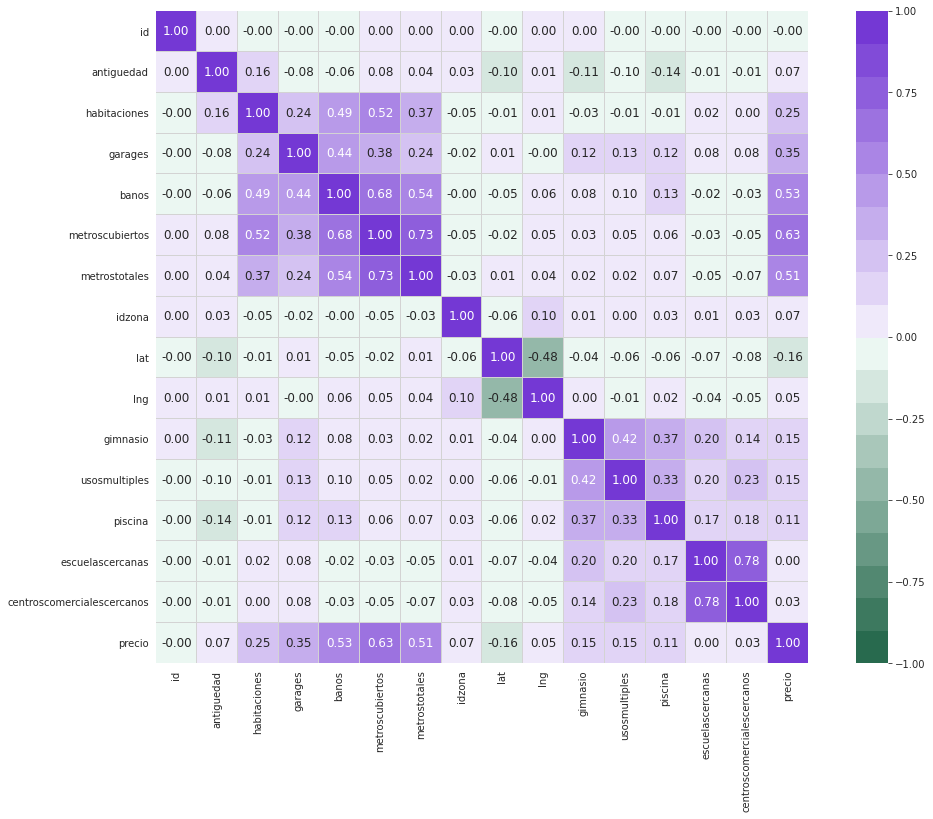

In [3]:
corr = corrHeatmap(data)["precio"].sort_values(ascending=False)

## Funciones para predicciones

In [674]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import statsmodels.formula.api as smf

def linearReg(df, features, prediction):
    dfFeat = df[features]

    y = df[prediction].values
    y = y.reshape(len(y),1)
    x = dfFeat.values
    x = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)
    predictions = linear_regressor.predict(x)
    
    return predictions


def getErrors(predictions, observed):
    error = metnum.LossFunctions()

    print("MSE   : %f" % (error.meanSquareError(observed, predictions)))
    print("MAE   : %f" % (error.meanAbsoluteError(observed, predictions)))
    print("RMSE  : %f" % (error.rootMeanSquareError(observed, predictions)))
    print("RMSLE : %f" % (error.rootMeanSquareLogError(observed, predictions)))

    #print("Elías no puede correr metnum")

    return

def linearRegressionTest(train, test, features, target):
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    
    #y = test[target].values
    #observed = y.reshape(len(y),1)
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle}
    
    return metrics

def linearRegression(train, test, features, target):
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle}
    
    return metrics, predictions, test

def linearRegressionPCR(train, test, features, target, alpha):
        
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    pca = metnum.PCA(alpha)
    pca.fit(xTrain)
    xTrain = pca.transform(xTrain)
    xTest = pca.transform(xTest)
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle, 'Features': alpha, 'Categoria': 'PCR'}
    
    return metrics

In [675]:
def forwardSelection(df, target): 
    # Selecciono la variable más correlacionada con prediction
    features = []
    mostCorrelatedVar = mostCorrelated(df, target)
    features.append(mostCorrelatedVar)
    
    eps = 0.001
    modelR2 = 0

    # Busco los features
    variables = list(df.columns)
    variables.remove(features[0])
    variables.remove(target[0])
            
    while(len(variables) > 0):
        nextFeature = {}
        kf = KFold(n_splits = 4)
        
        for trainidx, testidx in kf.split(df):
            maxR2 = 0
            maxVar = 0
        
            train = df[:trainidx[-1]]
            test = df[testidx[0]:testidx[-1]]
            
            for var in variables:
                categorias = features + [var]   
                metricas, predictions, test = linearRegression(train, test, categorias, target)
                modelo = getModel(categorias, target)
                actualR2, aic = getModelStatistics(predictions, test, target, modelo)

                if maxR2 < actualR2:
                    maxVar = var
                    maxR2  = actualR2
            
            if maxVar in nextFeature:
                nextFeature[maxVar].append(maxR2)
            else:
                nextFeature[maxVar] = [maxR2]
                
        maxVar, maxR2 = masFrecuente(nextFeature)
        if abs(modelR2 - maxR2) < eps or maxR2 < modelR2:
            break
        
        modelR2 = maxR2
        features.append(maxVar)
        variables.remove(maxVar)
    
    print("R2: %f" %(modelR2))
    
    #predictions = linearReg(df, features, target)

    #dfPred = df.copy()
    #dfPred['prediction'] = predictions
    #dfPred = dfPred[dfPred["prediction"] >= 0]
    
    #observed = dfPred[target].values
    #observed = observed.reshape(len(observed),1)
    
    #predictions = dfPred['prediction'].values
    #predictions = predictions.reshape(len(predictions),1)
    
    #getErrors(predictions, observed)

    return features

def forwardSelectionAIC(df, target):    
    # Selecciono la variable más correlacionada con prediction
    features = []
    mostCorrelatedVar = mostCorrelated(df, target)
    features.append(mostCorrelatedVar)
    
    predictions = linearReg(df, features, target)
    modelo = getModel(features, target)
    r2, modelAIC = getModelStatistics(predictions, df, target, modelo)
    eps = modelAIC * 0.0001
    
    # Busco los features
    variables = list(df.columns)
    variables.remove(features[0])
    variables.remove(target[0])
        
    while(len(variables) > 0):
        minVar = variables[0]
        categorias = features + [minVar]
        
        predictions = linearReg(df, categorias, target)
        modelo = getModel(categorias, target)
        r2, minAIC = getModelStatistics(predictions, df, target, modelo)
        
        for var in variables[1:]:
            categorias = features + [var]
            
            predictions = linearReg(df, categorias, target)
            modelo = getModel(categorias, target)
            r2, actualAIC = getModelStatistics(predictions, df, target, modelo)            
            
            if actualAIC < minAIC:
                minVar = var
                minAIC  = actualAIC
        
        if abs(modelAIC - minAIC) < eps or modelAIC < minAIC:
            break
        
        modelAIC = minAIC
        features.append(minVar)
        variables.remove(minVar)
    
    print("AIC: %f" %(modelAIC))
    predictions = linearReg(df, features, target)
    
    dfPred = df.copy()
    dfPred['prediction'] = predictions
    dfPred = dfPred[dfPred["prediction"] >= 0]
    
    observed = dfPred[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = dfPred['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    getErrors(predictions, observed)
    
    return features

## Predicciones de precios

In [823]:
data = pd.read_csv('../data/train.csv')
df = featureEng(data)

In [777]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.select_dtypes(include=numerics).columns.drop(["id", "precio"]).to_list()
target   = ["precio"]

dfs = {}
dfs = segmentaciones(df)

for segmentacion, dataframe in dfs.items():
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfs[segmentacion] = dataframe

In [778]:
modelosR2 = {}
for segmentacion, dataframe in dfs.items():
    print("Generando el modelo para %s" %(segmentacion))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosR2[segmentacion] = modelo
    
    print("\n===================================================================================================\n")

Generando el modelo para urbano
R2: 0.580027
precio ~ metroscubiertos + infracciones + seguridad + metrostotales + lat + banos + lng + habitaciones + garages + terraza


Generando el modelo para comercial
R2: 0.242079
precio ~ antiguedad + lng + garages


Generando el modelo para casa
R2: 0.641390
precio ~ metroscubiertos + infracciones + jardin + lat + garages + metrostotales + banos + antiguedad


Generando el modelo para depto
R2: 0.639071
precio ~ metrostotales + gimnasio + habitaciones + banos + garages + metroscubiertos + idzona + infracciones


Generando el modelo para bajos
R2: 0.583972
precio ~ metroscubiertos + infracciones + banos + seguridad + metrostotales + lat + lng + garages + habitaciones + antiguedad + jardin + terraza


Generando el modelo para medios
R2: 0.035250
precio ~ metrostotales + lng + lat + gimnasio + metroscubiertos


Generando el modelo para altos
R2: 0.000000
precio ~ piscina




\begin{tabular}{rrrrl}
\toprule
          MSE &           MAE &          RMSE &      RMSLE & Segmentacion \\
\midrule
 8.083760e+11 &  6.156777e+05 &  8.989101e+05 &   0.501725 &       urbano \\
 9.675784e+11 &  7.440149e+05 &  9.754757e+05 &   0.556960 &    comercial \\
 6.355735e+11 &  5.352839e+05 &  7.970698e+05 &   0.459059 &         casa \\
 1.163635e+12 &  7.669004e+05 &  1.078639e+06 &   0.512815 &        depto \\
 3.978590e+11 &  4.630910e+05 &  6.307478e+05 &   0.426388 &        bajos \\
 1.112644e+12 &  8.776981e+05 &  1.054570e+06 &   0.178532 &       medios \\
 7.649576e+13 &  7.846975e+06 &  8.738210e+06 &  14.107591 &        altos \\
\bottomrule
\end{tabular}



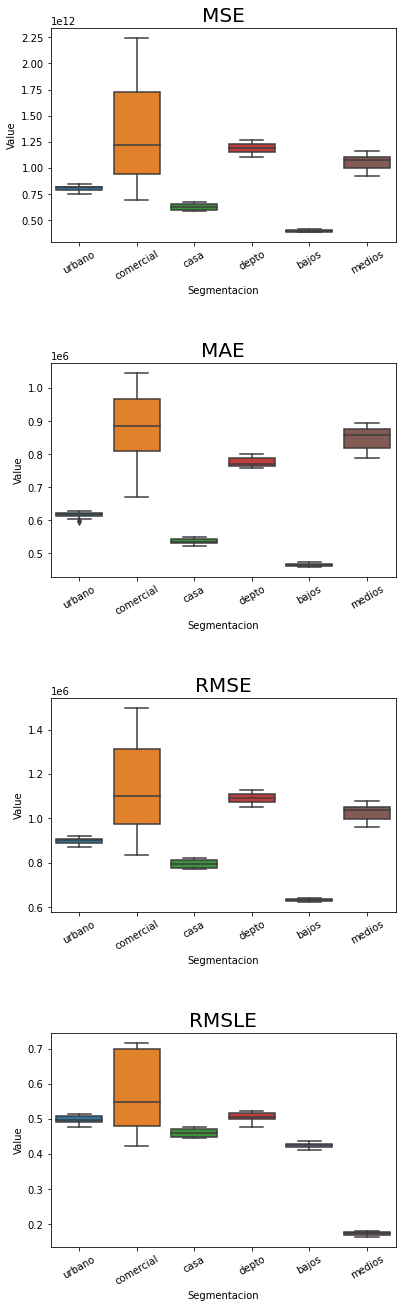

In [858]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])
#Ahora vemos las métricas que nos hayan dado para cada predicción. Podemos hacer un boxplot.
for segmentacion, dataframe in dfs.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosR2[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['precio'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
    
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (8,20))
fig.tight_layout(pad = 10.0)

dfMSE = dfMSE[dfMSE['Segmentacion'] != "altos"] 
dfMAE = dfMAE[dfMAE['Segmentacion'] != "altos"] 
dfRMSE = dfRMSE[dfRMSE['Segmentacion'] != "altos"] 
dfRMSLE = dfRMSLE[dfRMSLE['Segmentacion'] != "altos"] 

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)


bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)
figb = bplot4.get_figure()

In [ ]:
modelosAIC = {}

for segmentacion, dataframe in dfs.items():
    print("Generando el modelo para %s" %(segmentacion))
    modelo = forwardSelectionAIC(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosAIC[segmentacion] = modelo
    
    print("\n===================================================================================================\n")

## Segmentación por Provincias

In [837]:
df["provincia"].value_counts()

dfProv = df[df['provincia'].map(df['provincia'].value_counts()) > 5000]
dfProv["provincia"].value_counts()

dfCiudad = dfProv[dfProv['ciudad'].map(dfProv['ciudad'].value_counts()) > 3200]
dfCiudad["ciudad"].value_counts()

#dfCiudad[dfCiudad["ciudad"]== "Benito Juárez"]["tipodepropiedad"].value_counts()

Querétaro               12646
Benito Juárez           11013
Zapopan                 10360
San Luis Potosí          7925
Mérida                   7162
Monterrey                6946
Alvaro Obregón           6632
Naucalpan de Juárez      6554
Cuauhtémoc               6539
Miguel Hidalgo           5795
Atizapán de Zaragoza     5783
Tlalpan                  5721
Huixquilucan             5718
Coyoacán                 5293
Puebla                   4636
Guadalajara              4006
San Andrés Cholula       3805
Cuernavaca               3775
Tlalnepantla de Baz      3588
Cuautitlán Izcalli       3408
Tlajomulco de Zúñiga     3254
Name: ciudad, dtype: int64

In [838]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.select_dtypes(include=numerics).columns.drop(["id", "precio"]).to_list()
target   = ["precio"]

provincias = dfCiudad["provincia"].unique()
ciudades = dfCiudad["ciudad"].unique()

dfsProv = {}
dfsCiudad = {}

for provincia in provincias:
    dataframe = dfCiudad[dfCiudad["provincia"] == provincia]
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfsProv[provincia] = dataframe
    
for ciudad in ciudades:
    dataframe = dfCiudad[dfCiudad["ciudad"] == ciudad]
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfsCiudad[ciudad] = dataframe

In [827]:
modelosProv = {}
target = ['precio']
for provincia, dataframe in dfsProv.items():
    print("Generando el modelo para %s" %(provincia))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosProv[provincia] = modelo
    
    print("\n===================================================================================================\n")
    

Generando el modelo para Distrito Federal
R2: 0.536011
precio ~ metroscubiertos + banos + metrostotales + infracciones + seguridad + terraza + garages + idzona + habitaciones


Generando el modelo para Jalisco
R2: 0.702333
precio ~ metroscubiertos + metrostotales + antiguedad + garages + habitaciones + banos + infracciones + idzona


Generando el modelo para San luis Potosí
R2: 0.811628
precio ~ metroscubiertos + metrostotales + infracciones + antiguedad


Generando el modelo para Querétaro
R2: 0.854727
precio ~ metroscubiertos + metrostotales + indice_seguridad + infracciones + banos + piscina


Generando el modelo para Edo. de México
R2: 0.686718
precio ~ metroscubiertos + metrostotales + infracciones + banos + jardin


Generando el modelo para Nuevo León
R2: 0.791774
precio ~ metroscubiertos + antiguedad + metrostotales + infracciones + banos + habitaciones


Generando el modelo para Puebla
R2: 0.814552
precio ~ metroscubiertos + idzona + antiguedad + metrostotales + habitaciones + 

In [839]:
modelosCiudad = {}
target = ['precio']
for ciudad, dataframe in dfsCiudad.items():
    print("Generando el modelo para %s" %(ciudad))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosCiudad[ciudad] = modelo
    
    print("\n===================================================================================================\n")

Generando el modelo para Benito Juárez
R2: 0.597668
precio ~ metroscubiertos + garages + banos + infracciones


Generando el modelo para Zapopan
R2: 0.737613
precio ~ metroscubiertos + metrostotales + antiguedad + piscina


Generando el modelo para Coyoacán
R2: 0.579846
precio ~ metroscubiertos + garages + banos


Generando el modelo para San Luis Potosí
R2: 0.811628
precio ~ metroscubiertos + metrostotales + infracciones + antiguedad


Generando el modelo para Querétaro
R2: 0.859615
precio ~ metroscubiertos + metrostotales + indice_seguridad + infracciones + piscina


Generando el modelo para Naucalpan de Juárez
R2: 0.541409
precio ~ metroscubiertos + garages + jardin + banos


Generando el modelo para Monterrey
R2: 0.791774
precio ~ metroscubiertos + antiguedad + metrostotales + infracciones + banos + habitaciones


Generando el modelo para Puebla
R2: 0.763826
precio ~ metroscubiertos + banos + metrostotales + habitaciones + garages


Generando el modelo para Miguel Hidalgo
R2: 0.632

\begin{tabular}{rrrrl}
\toprule
          MSE &            MAE &          RMSE &     RMSLE &      Segmentacion \\
\midrule
 1.876874e+12 &  956574.171315 &  1.369678e+06 &  0.440647 &  Distrito Federal \\
 4.618972e+11 &  485031.163999 &  6.793701e+05 &  0.405569 &           Jalisco \\
 2.257050e+11 &  331088.747903 &  4.743172e+05 &  0.485733 &   San luis Potosí \\
 1.274490e+11 &  258819.416135 &  3.567878e+05 &  0.215187 &         Querétaro \\
 9.031499e+11 &  654438.988731 &  9.496286e+05 &  0.384262 &    Edo. de México \\
 4.077957e+11 &  500102.968634 &  6.363584e+05 &  0.430452 &        Nuevo León \\
 2.335522e+11 &  338385.639685 &  4.823802e+05 &  0.358860 &            Puebla \\
 1.768010e+11 &  311847.292838 &  4.175232e+05 &  0.322952 &           Yucatán \\
 4.286312e+11 &  467874.106469 &  6.525438e+05 &  0.295433 &           Morelos \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'RMSLE')

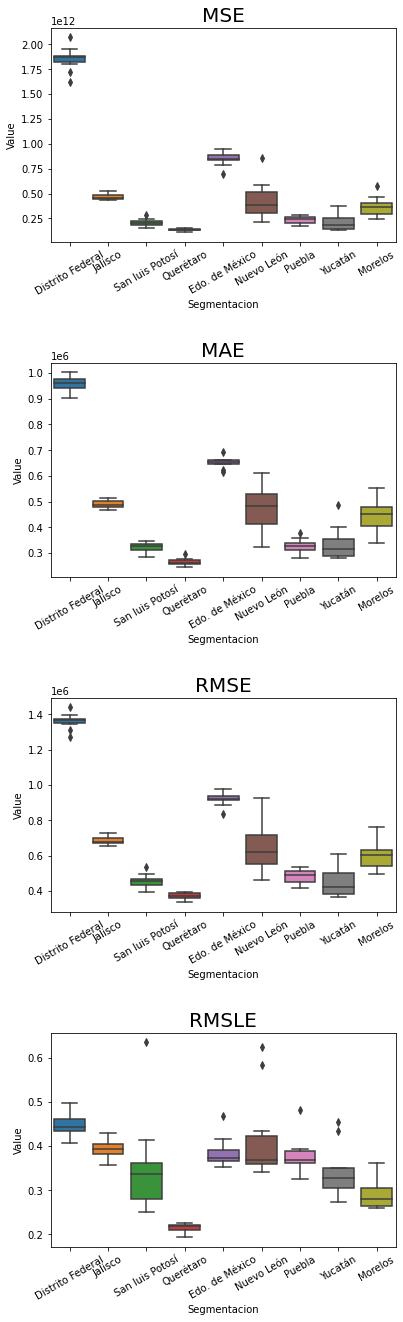

In [856]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

for segmentacion, dataframe in dfsProv.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosProv[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['precio'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
        
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (8,20))
fig.tight_layout(pad = 10.0)

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)

bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)

\begin{tabular}{rrrrl}
\toprule
          MSE &           MAE &          RMSE &     RMSLE &          Segmentacion \\
\midrule
 1.119006e+12 &  7.610916e+05 &  1.055340e+06 &  0.372685 &         Benito Juárez \\
 4.799724e+11 &  4.875945e+05 &  6.919646e+05 &  0.365895 &               Zapopan \\
 1.329003e+12 &  8.177077e+05 &  1.149445e+06 &  0.389544 &              Coyoacán \\
 2.257050e+11 &  3.310887e+05 &  4.743172e+05 &  0.485733 &       San Luis Potosí \\
 1.324563e+11 &  2.646407e+05 &  3.636322e+05 &  0.217435 &             Querétaro \\
 1.027676e+12 &  7.559919e+05 &  1.012943e+06 &  0.312022 &   Naucalpan de Juárez \\
 4.077957e+11 &  5.001030e+05 &  6.363584e+05 &  0.430452 &             Monterrey \\
 1.683341e+11 &  2.935183e+05 &  4.079378e+05 &  0.305361 &                Puebla \\
 3.310804e+12 &  1.365429e+06 &  1.817289e+06 &  0.537264 &        Miguel Hidalgo \\
 1.768010e+11 &  3.118473e+05 &  4.175232e+05 &  0.322952 &                Mérida \\
 2.538054e+12 &  1.19364

Text(0.5, 1.0, 'RMSLE')

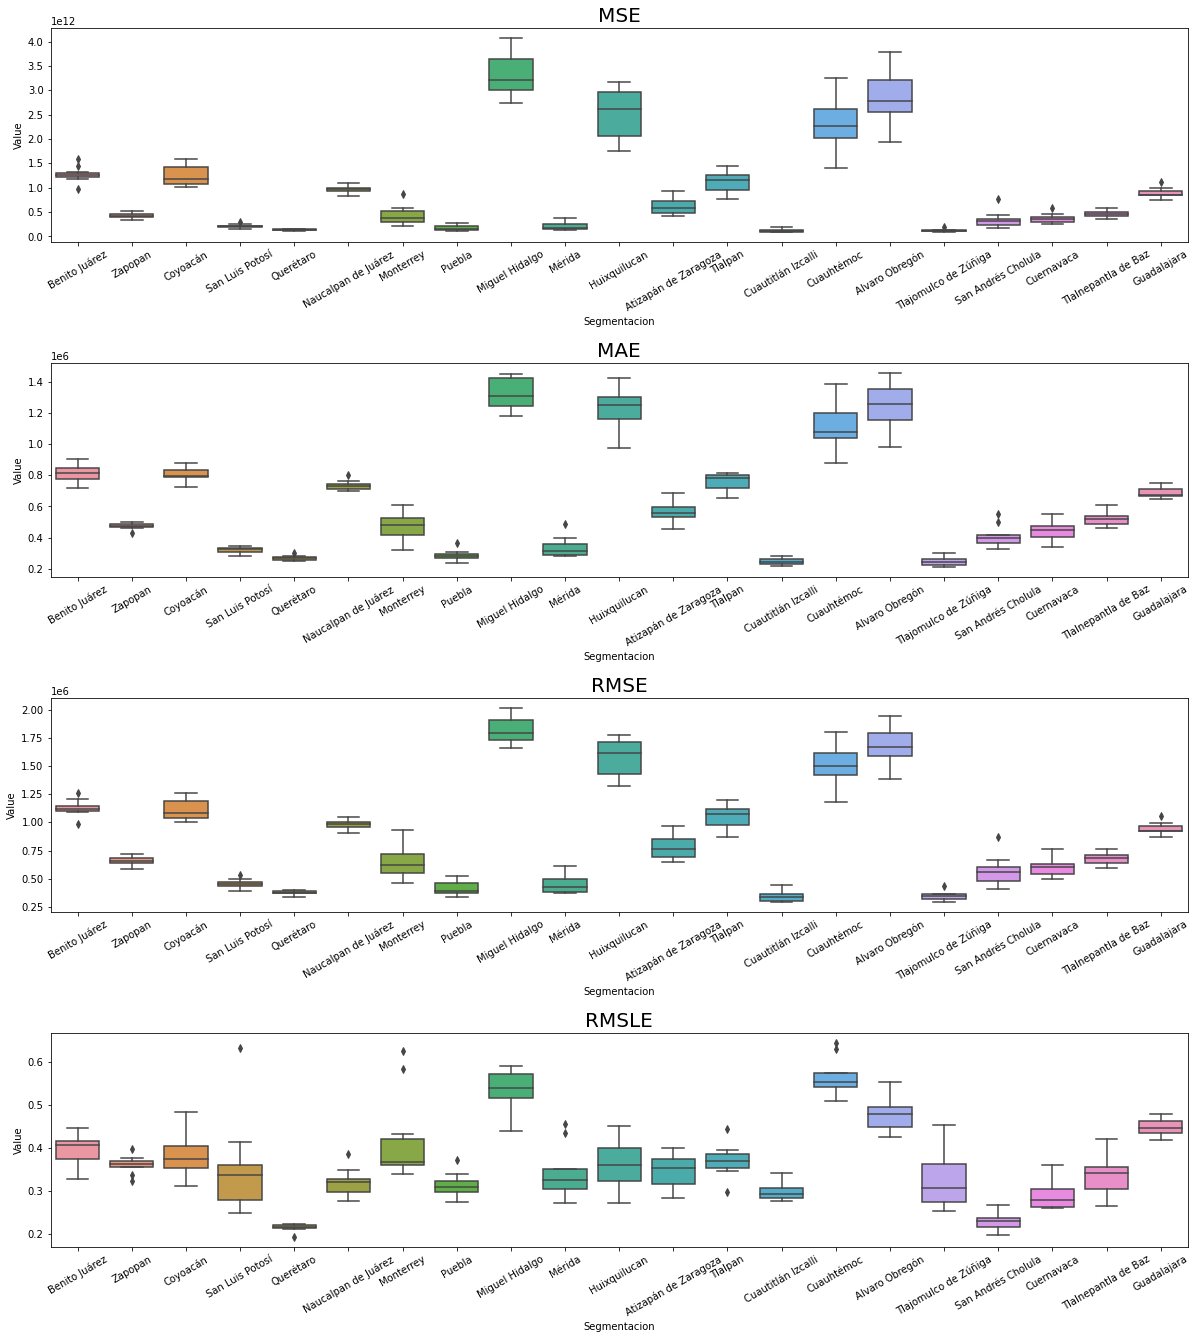

In [855]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

for segmentacion, dataframe in dfsCiudad.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosCiudad[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['precio'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
    
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (19,20))
fig.tight_layout(pad = 10.0)

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)

bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)


## Experimentación Cuantitativa

### PCR

In [648]:
#NO CORRER ESTA CELDA
import random
#Obtengo segmentación de deptos
dfAp = dfs.get("depto")
#modeloAp = modelosR2.get("depto")
modeloAp = forwardSelection(dfAp, ['precio'])

['metroscubiertos', 'gimnasio', 'antiguedad', 'garages', 'habitaciones', 'banos', 'metrostotales', 'idzona', 'jardin']
R2: 0.608413
MSE   : 1421317738018.194336
MAE   : 845071.695404
RMSE  : 1192190.311158
RMSLE : 0.511992
['metroscubiertos', 'gimnasio', 'antiguedad', 'garages', 'habitaciones', 'banos', 'metrostotales', 'idzona', 'jardin', 'terraza', 'piscina', 'lat', 'lng', 'seguridad', 'escuelascercanas', 'centroscomercialescercanos', 'indice_seguridad', 'infracciones', 'usosmultiples']


In [650]:
modeloShuffle = modeloAp
modeloShuffle = random.sample(modeloShuffle, len(modeloShuffle))
categorias = dfAp.columns.to_list()
categorias.pop(-1)

'precio'

In [651]:
dfPCR = pd.DataFrame(columns = metricas+['Categoria']+['Features'])
for cantFeatures in range(1, len(modeloAp)):
    
    kf = KFold(n_splits = 10)
    for trainidx, testidx in kf.split(dataframe):
        
        #preparo train y test
        train = dfAp[:trainidx[-1]]
        test = dfAp[testidx[0]:testidx[-1]]

        #Regresión lineal normal        
        features = modeloAp[:cantFeatures]
        newMetricas = linearRegressionTest(train, test, features, ['precio'])
        newMetricas['Categoria'] = 'Normal'
        newMetricas['Features'] = cantFeatures
        dfPCR = dfPCR.append(newMetricas, ignore_index = True)


        #Regresión lineal shuffled
        features = modeloShuffle[:cantFeatures]
        newMetricas = linearRegressionTest(train, test, features, ['precio'])
        newMetricas['Categoria'] = 'Shuffle'
        newMetricas['Features'] = cantFeatures
        dfPCR = dfPCR.append(newMetricas, ignore_index = True)

        #PCR
        newMetricas = linearRegressionPCR(train, test, categorias, ['precio'], cantFeatures)
        dfPCR = dfPCR.append(newMetricas, ignore_index = True)
        
dfPCR = dfPCR.groupby(['Categoria', 'Features']).mean().reset_index()
#print(dfPCR)


/home/schuster/.virtualenvs/metnum/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/schuster/.virtualenvs/metnum/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



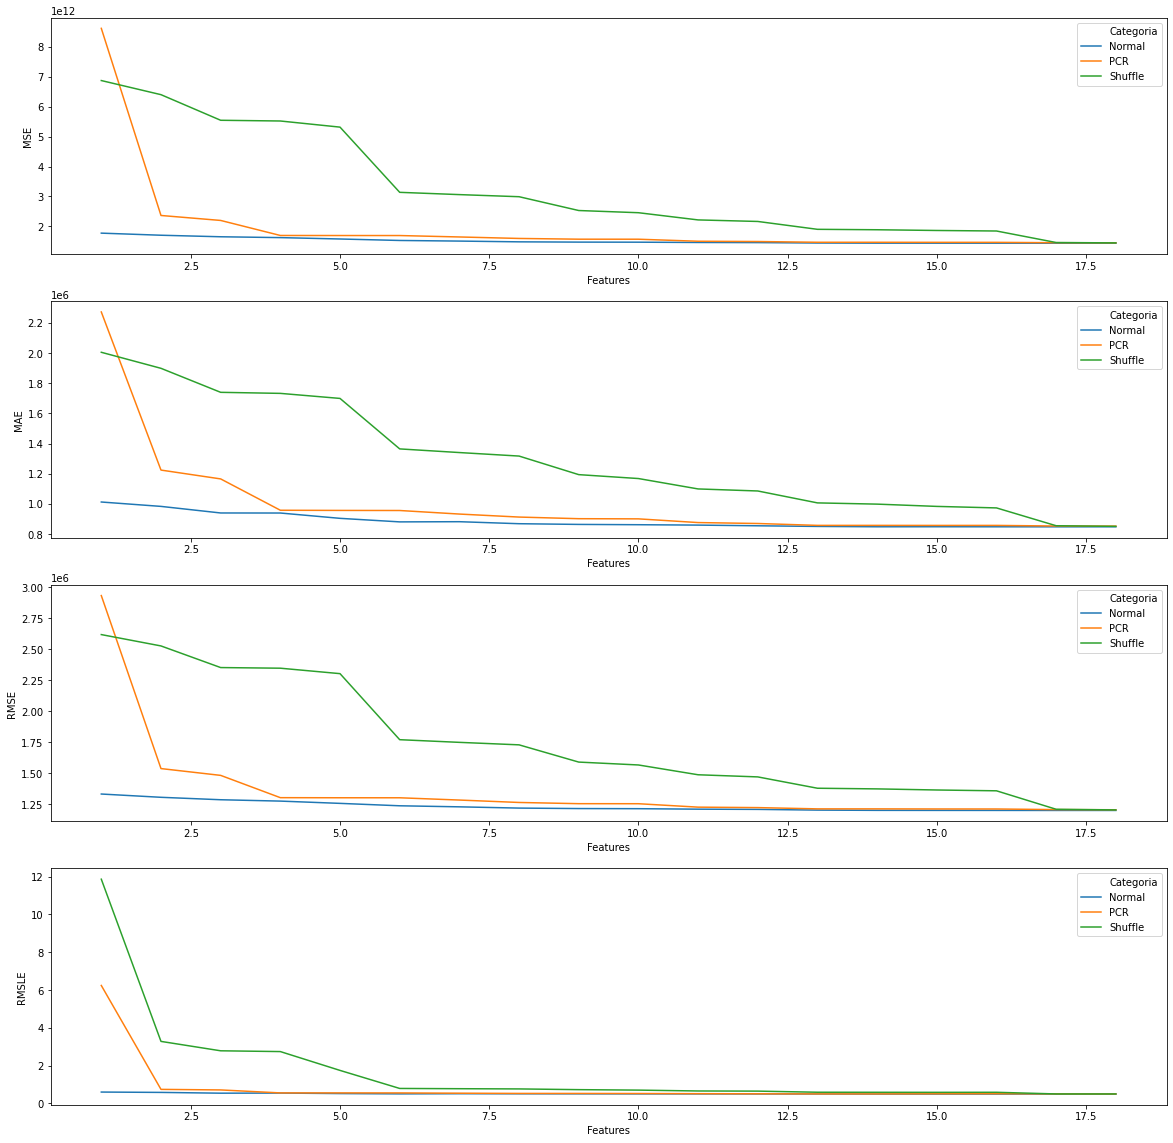

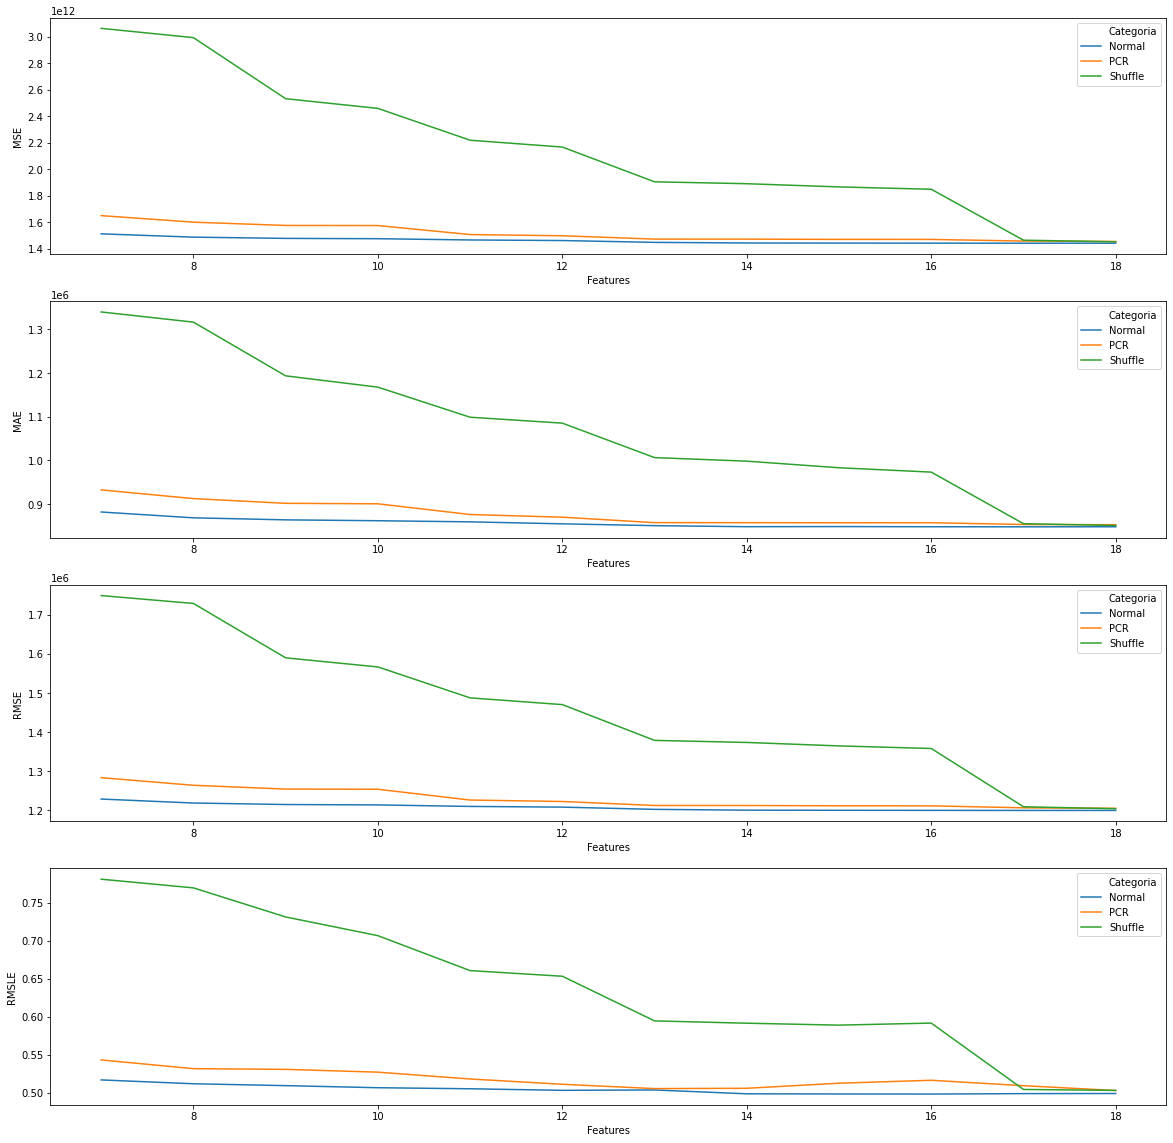

In [742]:
fig, axs = plt.subplots(nrows = 4, figsize = (20,20))
ax2 = sns.lineplot(x="Features", y="MSE", data=dfPCR, hue = 'Categoria',  ax=axs[0])
ax1 = sns.lineplot(x="Features", y="MAE", data=dfPCR, hue = 'Categoria', ax=axs[1])
ax3 = sns.lineplot(x="Features", y="RMSLE", data=dfPCR, hue = 'Categoria',  ax=axs[3])
ax = sns.lineplot(x="Features", y="RMSE", data=dfPCR, hue = 'Categoria',  ax=axs[2])

dfPCR2 = dfPCR[dfPCR["Features"]>6]

fig, axs = plt.subplots(nrows = 4, figsize = (20,20))
ax2 = sns.lineplot(x="Features", y="MSE", data=dfPCR2, hue = 'Categoria',  ax=axs[0])
ax1 = sns.lineplot(x="Features", y="MAE", data=dfPCR2, hue = 'Categoria', ax=axs[1])
ax3 = sns.lineplot(x="Features", y="RMSLE", data=dfPCR2, hue = 'Categoria',  ax=axs[3])
ax = sns.lineplot(x="Features", y="RMSE", data=dfPCR2, hue = 'Categoria',  ax=axs[2])


### Remover Outliers

In [770]:
data = pd.read_csv('../data/train.csv')
df = featureEng(data)

In [784]:
#Incorporar
dfApartamento = df[df["tipodepropiedad"] == "Apartamento"]
target = ['precio']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = modelosR2.get("depto")
dfApartamento = dfApartamento[features+target]
dfApartamento.info()
print(features)
target   = ["precio"]

dfOutliers = pd.DataFrame(columns = metricas+["Metodo"])

kf = KFold(n_splits = 5)
for trainidx, testidx in kf.split(dfApartamento):
    train = dfApartamento[:trainidx[-1]]
    test = dfApartamento[testidx[0]:testidx[-1]]
    
    trainNan = train.dropna()
    testNan = test.dropna()

    train = train.fillna(train.median())    
    test = test.fillna(test.median())
    
    trainNanOut = removeOutliers(trainNan, features, target)
    testNanOut = removeOutliers(testNan, features, target)
    
    trainOut = removeOutliers(train, features, target)
    testOut = removeOutliers(test, features, target)
    
    train = train.loc[:, (train != 0).any(axis=0)]
    trainNan = trainNan.loc[:, (trainNan != 0).any(axis=0)]
    trainNanOut = trainNanOut.loc[:, (trainNanOut != 0).any(axis=0)]
    trainOut = trainOut.loc[:, (trainOut != 0).any(axis=0)]
    
    test = test.loc[:, (test != 0).any(axis=0)]
    testNan = testNan.loc[:, (testNan != 0).any(axis=0)]
    testNanOut = testNanOut.loc[:, (testNanOut != 0).any(axis=0)]
    testOut = testOut.loc[:, (testOut != 0).any(axis=0)]
    
    newMetricas = linearRegressionTest(train, test, features, target)
    newMetricas['Metodo'] = 'Con outliers y rellenando NaN'
    dfOutliers = dfOutliers.append(newMetricas, ignore_index = True)
    
    newMetricas = linearRegressionTest(trainOut, testOut, features, target)
    newMetricas['Metodo'] = 'Sin outliers y rellenando NaN'
    dfOutliers = dfOutliers.append(newMetricas, ignore_index = True)
    
    newMetricas = linearRegressionTest(trainNan, testNan, features, target)
    newMetricas['Metodo'] = 'Con outliers y sacando NaN'
    dfOutliers = dfOutliers.append(newMetricas, ignore_index = True)
    
    newMetricas = linearRegressionTest(trainNanOut, testNanOut, features, target)
    newMetricas['Metodo'] = 'Sin outliers y sacando NaN'
    dfOutliers = dfOutliers.append(newMetricas, ignore_index = True)

dfOutliers = dfOutliers.groupby(['Metodo']).mean().reset_index()
print(dfOutliers)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57300 entries, 0 to 239999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   metrostotales    29334 non-null  float64
 1   gimnasio         57300 non-null  float64
 2   habitaciones     56311 non-null  float64
 3   banos            55982 non-null  float64
 4   garages          53589 non-null  float64
 5   metroscubiertos  56482 non-null  float64
 6   idzona           52779 non-null  float64
 7   infracciones     57300 non-null  float64
 8   precio           57300 non-null  float64
dtypes: float64(9)
memory usage: 4.4 MB
['metrostotales', 'gimnasio', 'habitaciones', 'banos', 'garages', 'metroscubiertos', 'idzona', 'infracciones']
                          Metodo           MSE            MAE          RMSE  \
0  Con outliers y rellenando NaN  2.084022e+12  990645.490270  1.443521e+06   
1     Con outliers y sacando NaN  1.884104e+12  942557.613781  1.372560e+06 

### No correr, análisis de todos los subconjuntos. (Tarda un siglo)

In [ ]:
# SUBCONJUNTOS

def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]
        
predictions = linearReg(df, ["metroscubiertos"], target)
modelo = getModel(["metroscubiertos"], target)
r2, aic = getModelStatistics(predictions, df, target, modelo)

minAIC = aic
modelo = ["metroscubiertos"]

for features in powerset(features):
    if features == []:
        continue

    predictions = linearReg(df, features, target)
    modelo = getModel(features, target)
    r2, aic = getModelStatistics(predictions, df, target, modelo)
    
    if aic < minAIC:
        minAIC = aic
        modelo = features
        
print("AIC    : %f\nModelo : %s" % (minAIC, printModelo(modelo)))

In [ ]:
def printModelo(modelo):
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    return imprimir